# ALIGNED project: Model uncertainty tutorial

**Aligning Life Cycle Assessment methods and bio-based sectors for improved environmental performance**

[http://www.alignedproject.eu/](http://www.alignedproject.eu/)

_Horizon Europe grant agreement N° 101059430. Views and opinions expressed are however those of the author(s) only and do not necessarily reflect those of the European Union or the European Research Executive Agency._ 


## WP1 Shared modelling framework and learnings
### Task 1.4 Framework for interpreting uncertainty

#### Deliverable 1.2 Description of scientific methods

#### Tutorial for performing the analysis of model uncertainty

#### Massimo Pizzol, Aalborg University (AAU), 2024

This notebook show how to perform a uncertainty analysis for a example product system of a biobased product, and quantify the uncertainty due to a specific modelling choice, in this case the choice of electricity mix.

In [1]:
# importing packages
import bw2data as bd
import bw2calc as bc
import pandas as pd
import numpy as np
from scipy import stats
from lci_to_bw2 import * # import all the functions of this module

In [2]:
# open a project with ecoinvent v.3.11 consequential system model
bd.projects.set_current('advlca25')

We start by importing a dummy prodcut system of a biobased product

We start by importing data about a fictional ("dummy") product system for a biobased product.

In [3]:
# Import the dummy product system

# import data from csv
mydata = pd.read_csv('ALIGNED-LCI-biobased-product-dummy.csv', header = 0, sep = ",") # using csv file avoids encoding problem
mydata.head()

# keep only the columns not needed
mydb = mydata[['Activity database','Activity code','Activity name','Activity unit','Activity type',
               'Exchange database','Exchange input','Exchange amount','Exchange unit','Exchange type',
               'Exchange uncertainty type','Exchange loc','Exchange scale','Exchange negative', 
               'Simapro name',	'Simapro unit', 'Simapro type']].copy()

mydb = mydata.copy()

mydb['Exchange uncertainty type'] = mydb['Exchange uncertainty type'].fillna(0).astype(int) # uncertainty as integers
# Note: to avoid having both nan and values in the uncertainty column I use zero as default

# Create dictionary in bw format and write database to disk. 
# Shut down all other notebooks using the same project before doing this
bw2_db = lci_to_bw2(mydb) # a function from the lci_to_bw2 module

# write database
bd.Database('ALIGNED-biob-prod-dummy').write(bw2_db)

# check what foreground activities are included
for act in bd.Database('ALIGNED-biob-prod-dummy'):
    print(act, act['code'])

10:05:15 [warning  ] Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 5/5 [00:00<00:00, 922.68it/s]

10:05:15 [info     ] Vacuuming database            


'Biobased-product-manufacturing' (kilogram, None, None) a37d149a-6508-4563-8af6-e5a39b4176df
'Biobased-product-eol' (kilogram, None, None) c8301e73-d521-4a89-998b-30b7e7751011
'Biomass-processing' (kilogram, None, None) 403a5c32-c769-46fc-8b9a-74b8eb3c79d1
'Biobased-product-use' (year, None, None) f9eabf64-b899-40c0-9f9f-2009dbb0a0b2
'Biomass-growth' (kilogram, None, None) a7d34649-9c10-4423-bac3-ecab9b43b20c


In [4]:
# More info 
myact = bd.Database('ALIGNED-biob-prod-dummy').get('f9eabf64-b899-40c0-9f9f-2009dbb0a0b2') # Biobased-product-use
myact._data

{'name': 'Biobased-product-use',
 'unit': 'year',
 'type': 'processwithreferenceproduct',
 'database': 'ALIGNED-biob-prod-dummy',
 'code': 'f9eabf64-b899-40c0-9f9f-2009dbb0a0b2',
 'id': 161399820538093568}

We calculate a static climate impact score for the fictional biobased product, to be used for reference later on.

In [5]:
# calculation of static LCA score
mymethod = ('ecoinvent-3.11', 'IPCC 2021', 'climate change: fossil', 'global warming potential (GWP100)')
myact = bd.Database('ALIGNED-biob-prod-dummy').get('f9eabf64-b899-40c0-9f9f-2009dbb0a0b2') # Biobased-product-use
functional_unit = {myact: 1}
LCA = bc.LCA(functional_unit, mymethod)
LCA.lci()
LCA.lcia()
print("The static Global Warming impact score is", LCA.score, bd.methods[mymethod]['unit'])

The static Global Warming impact score is 180.28497357367456 Unknown


### Perform uncertainty analysis on a specific modelling choice

One might for example lack specific knowledge regarding where a product is produced or used and thus be interested in changing the electricity mix to understant what is the range of results that can be obtained due to this choice or spatial veriability. 

In this example, the LCA is run with **different electricity market mixes** randmoly chosen from ecoinvent instead of just one.

In the product system under analysis, electricity is used in the manufacturing process.

In [6]:
# Select the manufacturing activity.
myact = bd.Database('ALIGNED-biob-prod-dummy').get('a37d149a-6508-4563-8af6-e5a39b4176df') # Biobased-product-manufacturing
myact._data

{'name': 'Biobased-product-manufacturing',
 'unit': 'kilogram',
 'type': 'processwithreferenceproduct',
 'database': 'ALIGNED-biob-prod-dummy',
 'code': 'a37d149a-6508-4563-8af6-e5a39b4176df',
 'id': 161399820533899266}

Specifically, it is electricity from the Danish market, medium voltage.

In [7]:
for exc in list(myact.exchanges()):
    print(exc)

Exchange: 1.0 kilogram 'Biobased-product-manufacturing' (kilogram, None, None) to 'Biobased-product-manufacturing' (kilogram, None, None)>
Exchange: 0.5 kilogram 'Biomass-growth' (kilogram, None, None) to 'Biobased-product-manufacturing' (kilogram, None, None)>
Exchange: 0.5 kilogram 'Biomass-processing' (kilogram, None, None) to 'Biobased-product-manufacturing' (kilogram, None, None)>
Exchange: 0.5 kilowatt hour 'market for electricity, medium voltage' (kilowatt hour, DK, None) to 'Biobased-product-manufacturing' (kilogram, None, None)>


#### Step 1

First make a list of electricity markets we want to test. 


In [8]:
el_markets = [('ecoinvent-3.11-consequential', i['code']) 
              for i in bd.Database("ecoinvent-3.11-consequential").search('market electricity medium voltage', limit = 100)]
el_markets[1:5] # prints the first four of them

[('ecoinvent-3.11-consequential', 'a0bb85be81d6cba0886be5f658683e5d'),
 ('ecoinvent-3.11-consequential', 'f18e3ec71c601bcb47d4ecd049564a3b'),
 ('ecoinvent-3.11-consequential', '45aef1f2706fe1facc3d955171c3eecf'),
 ('ecoinvent-3.11-consequential', '664330c023e9c446c20024ed42caea24')]

Now we substitute these in the product system instead of the current electricity

In [9]:
# Get the activity, substitute the background process, save, and calculate
el_loc_results = [] # empty list that will contain all the results of the local SA
bb_manuf = bd.Database('ALIGNED-biob-prod-dummy').get('a37d149a-6508-4563-8af6-e5a39b4176df')
for m in el_markets[0:30]: # I am taking 30 different electticity markets
    exc = list(bb_manuf.exchanges())[3] # select the first exchange in the activity, i.e. the input from ecoinvent
    exc['input'] = m
    exc.save() # important or the changes won't be maintained
    lca = bc.LCA(functional_unit, mymethod)
    lca.lci()
    lca.lcia()
    el_loc_results.append(lca.score)

Let's look at the results

In [10]:
el_loc_results[1:10]

[179.91606725891018,
 197.36887442898467,
 185.36275136980956,
 186.25249074874932,
 195.94751909710513,
 210.24912422514961,
 180.0509223821751,
 192.4265455522242,
 196.12821205079837]

We can get quick descriptive statistics of the distribution of results including a median value (50% percentile) and a quantitative measure of uncertainty in terms of standard deviation (std)

In [11]:
pd.DataFrame(el_loc_results, columns = ['GWI scores']).describe()

,GWI scores
count,3.000000e+01
mean,6.756865e+04
std,3.690417e+05
min,1.798270e+02
25%,1.853657e+02
50%,1.951931e+02
75%,1.961282e+02
max,2.021516e+06


Note that the median is higher than the static value calculated in the beginning, a sign that the default system using Danish electricity mix is in the lower end of the potential range of impacts.

We can also have a visual look at the uncertainty.

In [12]:
from matplotlib import pyplot as plt

Text(0.5, 0, 'Use of biobased product')

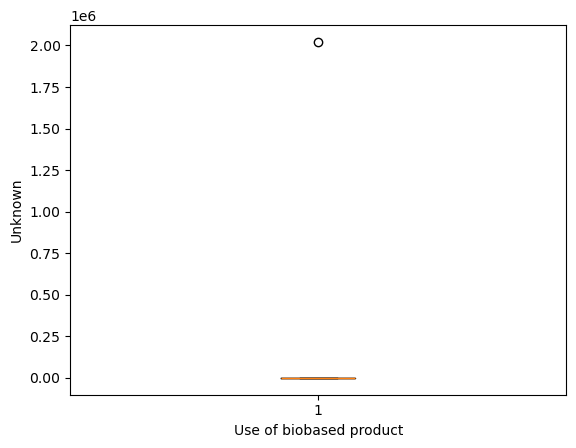

In [16]:
# Using matplotlib package
plt.boxplot(el_loc_results)
plt.ylabel(bd.methods[mymethod]['unit'])
plt.xlabel('Use of biobased product')